# 1. Chargement du dataset

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Graine pour la reproductibilité
tf.keras.utils.set_random_seed(24)
tf.config.experimental.enable_op_determinism()

# Dataframe PVF-10
csv_pvf10 = "../data/processed/structure_pvf_10.csv"

# Répertoire des résultats
results_dir = "DL_images_results"

In [2]:
from sklearn.model_selection import train_test_split

# Charger le dataframe à partir du dataset
def load_df_from_dataset(csv_path,*,format,originalTrainTest=False,removeCarre=False):
    # Charger le fichier CSV et filtrer sur le format sélectionné
    df_pvf10 = pd.read_csv(csv_path)
    df_pvf10 = df_pvf10.loc[(df_pvf10['Format'] == format)]
    # Retrait éventuel des images carrées mises en doute lors de l'analyse exploratoire
    if removeCarre:
        df_pvf10 = df_pvf10.loc[~df_pvf10['Doute_Carre']]
    # Si on utilise le découpage train/test proposé par les créateurs du dataset
    if originalTrainTest:
        df_train = df_pvf10.loc[(df_pvf10['Train_Test'] == 'train')]  
        df_test = df_pvf10.loc[(df_pvf10['Train_Test'] == 'test')] 
        X_train = df_train.drop('Classe',axis=1)
        y_train = df_train['Classe']
        X_test = df_test.drop('Classe',axis=1)
        y_test = df_test['Classe']
    # Sinon découpage train/test en 80/20 avec conservation de la répartition des classes
    else:
        X = df_pvf10.drop('Classe',axis=1)
        y = df_pvf10['Classe']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    
    return X_train,X_test,y_train,y_test

# Charger les images au format 110x60 avec le découpage train / test d'origine (90% / 10%)  
# On réserve 20% de train pour la validation
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60",originalTrainTest="True")
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42,stratify=y_train)

print ("Nb d'images ensemble d'entraînement :",X_train.shape[0])
print ("Nb d'images ensemble de validation :",X_val.shape[0])
print ("Nb d'images ensemble de test :",X_test.shape[0])
print ("-"*20)
print ("Répartition des classes, ensemble d'entraînement :")
print(y_train.value_counts(normalize=True))
print ("-"*20)
print ("Répartition des classes, ensemble de validation :")
print(y_val.value_counts(normalize=True))
print ("-"*20)
print ("Répartition des classes, ensemble de test :")
print(y_test.value_counts(normalize=True))

pd.set_option('display.max_columns', None)

Nb d'images ensemble d'entraînement : 4015
Nb d'images ensemble de validation : 1004
Nb d'images ensemble de test : 553
--------------------
Répartition des classes, ensemble d'entraînement :
Classe
healthy panel             0.271980
hot cell                  0.169365
junction box heat         0.143462
substring open circuit    0.106600
short circuit panel       0.076712
Debris cover              0.073474
bottom dirt               0.067746
shadow                    0.054296
break                     0.023661
string short circuit      0.012702
Name: proportion, dtype: float64
--------------------
Répartition des classes, ensemble de validation :
Classe
healthy panel             0.271912
hot cell                  0.169323
junction box heat         0.143426
substring open circuit    0.106574
short circuit panel       0.076693
Debris cover              0.073705
bottom dirt               0.067729
shadow                    0.054781
break                     0.022908
string short circuit     

# 2. Preprocessing

Nous passerons en entrée de notre modèle un **tf.data.Dataset découpé en batch de 32 images**. Celles-ci seront **redimensionnées** au format 110x60 (pour rappel, 4% des images ne le sont pas) et **converties en niveaux de gris** dans le preprocessing.

In [3]:
# Features : récupération des chemins d'images
X_train_path = X_train['Chemin'].values
X_val_path = X_val['Chemin'].values
X_test_path = X_test['Chemin'].values

# Targets : Encodage des classes en entier
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc = encoder.transform(y_val)
y_test_enc = encoder.transform(y_test)

# Fonction de preprocessing
def preprocess_path(path, label):
    image = tf.io.read_file(path) # Lecture du fichier
    image = tf.image.decode_png(image, channels=3) # Chargement de l'image 
    image = tf.image.rgb_to_grayscale(image) # Conversion en niveaux de gris
    image = tf.image.resize(image, [110, 60]) # Redimensionnement en 110x60
    return image, label

# Création des datasets tensorflow
train_ds = tf.data.Dataset.from_tensor_slices((X_train_path, y_train_enc))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val_enc))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_path, y_test_enc))

# Preprocessing
train_ds = train_ds.map(preprocess_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_path, num_parallel_calls=tf.data.AUTOTUNE)

# Optimisation de la pipeline
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Nombre de batch dans train_ds:", train_ds.cardinality().numpy())
print("Nombre de batch dans val_ds:", val_ds.cardinality().numpy())
print("Nombre de batch dans test_ds:", test_ds.cardinality().numpy())

Nombre de batch dans train_ds: 126
Nombre de batch dans val_ds: 32
Nombre de batch dans test_ds: 18


# 3. Construction du modèle CNN

Nous construisons un modèle CNN basé sur l'architecture suivante :
- couche d'entrée au format (110,60,1)
- couche de normalisation
- couches d'augmentation des données
- couches d'extraction de features : basé sur couches de convolution et maxpooling
- couche de passage en 1D
- couches de classification : basé sur couches denses

Pour plus de flexibilité, nous définissons une fonction qui construit un modèle en rendant paramétrables certains aspects de cette architecture 

In [4]:
# Importations des couches du modèle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomBrightness
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense

# Construction du modèle
def build_model(augmentation = False, nb_conv_layers = 4, nb_filters_first_layer=32, globalAveragePooling = False,light_dense=False):
    """
    Construit un modèle CNN adaptable pour la classification d'images 110x60.

    Args:
        augmentation (bool): Si True, applique des couches d'augmentation de données aux images.
        nb_conv_layers (int): Nb de couches de convolution (typiquement 3 ou 4)
        nb_filters_first_layer (int): Nb de filtres dans la première couche convolutionnelle (typiquement 16 ou 32)
        globalAveragePooling (bool) : Si True, utilise GlobalAveragePooling au lieu de Flatten avant la classification
        light_dense (bool) : Si True, réduit le nombre de couches denses pour la classification

    Returns:
        keras.Model: Le modèle CNN compilé, prêt à l'entraînement.
    """
    # Entrée
    inputs = Input(shape=(110,60,1))

    # Augmentation
    if augmentation:
        x = RandomFlip("horizontal_and_vertical")(inputs)
        x = RandomBrightness(factor=0.1)(x)
        x = RandomContrast(factor=0.1)(x)
        x = GaussianNoise(0.03)(x)
        # Normalisation
        x = Rescaling(scale=1./255.)(x)
    else :
        # Normalisation
        x = Rescaling(scale=1./255.)(inputs)

    
    # Couches de convolution
    for num_block in range(nb_conv_layers):
        x = Conv2D(filters=nb_filters_first_layer * (2**num_block), kernel_size=(3,3), padding="same", activation ="relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)

    # Passage 1-D pour la classification
    if globalAveragePooling:
        x = GlobalAveragePooling2D()(x)
    else:
        x = Flatten()(x)

    # Couches de classification
    if not light_dense:
        x = Dense(units = 128, activation='relu')(x)
        x = Dropout(0.2)(x)
    x = Dense(units = 64, activation='relu')(x)

    # Sortie
    outputs = Dense(units = 10, activation = 'softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return(model)

# 4. Optimisation de l'architecture

Pour limiter les risques de sur-apprentissage, nous allons utiliser 2 callbacks : EarlyStopping et ReduceLROnPlateau

In [5]:
# Arrêt après 5 époques si la perte sur l'ensemble de validation ne diminue plus
from tensorflow.keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor = 'val_loss',
                               mode = 'min',
                               patience = 5,
                               verbose = 1,
                               restore_best_weights=True)

# Taux d'apprentissage divisé par 2 si la perte sur l'ensemble de validation ne diminue plus après 3 époques.
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                               mode = 'min',
                               patience = 3,
                               factor = 0.5, 
                               min_lr=1e-6,
                               verbose = 1)

Nous définissons dès maintenant une fonction de prédiction : celle-ci sera utilisée sur l'ensemble de validation et permettra notamment de calculer le f1-score

In [6]:
# Fonction de prédiction d'un dataset
def get_predictions_and_labels(model,dataset):
    true_labels = []
    pred_labels = []
    # Pour chaque batch du dataset
    for images, labels in dataset:
        preds = model.predict(images, verbose=0) # Prédiction sur les images du batch : on récupère une proba par classe
        pred_labels.extend(np.argmax(preds, axis=-1)) # On stocke la classe de la meilleure des proba pour toutes les images du batch
        true_labels.extend(labels.numpy()) # On stocke la vraie classe pour toutes les images du batch
    # On renvoie un tableau des vraies classes et des classes prédites pour l'ensemble des batches du dataset
    return np.array(true_labels), np.array(pred_labels)

Nous utilisons une **grille de paramétrage** afin de comparer plusieurs architectures de modèle. Pour chaque architecture, on enregistre le temps d'entraînement, le nb d'époques, l'accuracy et le f1-score macro sur le jeu de validation.

L'entraînement sera effectué avec la fonction de perte sparse_categorical_entropy, adaptée aux problèmes de classification multi-classes, et l'optimiseur Adam.

In [7]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score,accuracy_score
import time

# On testera l'augmentation des données dans un second temps
cnn_param_grid = {
    'augmentation': [False],
    'nb_conv_layers': [3,4],
    'nb_filters_first_layer': [16,32],
    'globalAveragePooling': [False,True],
    'light_dense': [False,True]
}

# Fonction d'entraînement du réseau de neurones
def fit_validate_model(cnn_param_grid,train_ds,val_ds,nb_epoques,tx_appr=0.001) : 
    
    # Pour stockage des résultats
    results = []

    # Pour chaque combinaison de paramètres
    for params in ParameterGrid(cnn_param_grid):

        # Lancer le chronomètre pour temps d'entraînement
        start = time.time()
    
        # Construire le modèle avec les paramètres indiqués
        model = build_model(**params)

        # Le compiler avec optimiseur Adam et fonction de perte adaptée aux problèmes multi-classes
        model.compile(loss="sparse_categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(tx_appr),
            metrics=["accuracy"])

        # L'entraîner
        history = model.fit(train_ds, epochs=nb_epoques, validation_data=val_ds,
                callbacks=[early_stopping,reduce_learning_rate])

        # Arrêter le chronomètre 
        end = time.time()

        # Récupérer le temps d'entraînement et le nb d'époques
        training_time = end - start
        nb_epochs = len(history.history['val_accuracy'])
    
        # Effectuer les prédictions sur val
        y_val_true, y_val_pred = get_predictions_and_labels(model,val_ds)
        # Calculer l'accuracy et le f1-score sur val
        accu = accuracy_score(y_val_true, y_val_pred) 
        f1 = f1_score(y_val_true, y_val_pred, average='macro')
            
        # Stockage / affichage des résultats et paramètres associés
        results.append({**params,
                        'training_time': training_time,
                        'nb_epochs': nb_epochs,
                        'accuracy': accu,
                        'f1_macro': f1,
                        })

    # Afficher le compte-rendu des résultats
    display (pd.DataFrame(results).sort_values('f1_macro',ascending=False))
    return results

In [35]:
results = fit_validate_model(cnn_param_grid,train_ds,val_ds,50,0.001)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2240 - loss: 2.1207 - val_accuracy: 0.2719 - val_loss: 2.0925 - learning_rate: 0.0010
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2765 - loss: 1.9988 - val_accuracy: 0.4273 - val_loss: 1.7173 - learning_rate: 0.0010
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4807 - loss: 1.5527 - val_accuracy: 0.5777 - val_loss: 1.2818 - learning_rate: 0.0010
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5982 - loss: 1.2175 - val_accuracy: 0.6604 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6664 - loss: 1.0535 - val_accuracy: 0.7331 - val_loss: 0.8557 - learning_rate: 0.0010
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7015 - loss: 0.8891 - val_accuracy: 0.7351 - val_loss: 0.7908 - learning_rate: 0.0010
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7421 - loss: 0.

,augmentation,globalAveragePooling,light_dense,nb_conv_layers,nb_filters_first_layer,training_time,nb_epochs,accuracy,f1_macro
15,False,True,True,4,32,784.905004,50,0.892430,0.806119
3,False,False,False,4,32,492.451399,35,0.870518,0.769426
11,False,True,False,4,32,741.822818,50,0.862550,0.769167
10,False,True,False,4,16,313.310225,50,0.876494,0.768928
0,False,False,False,3,16,153.829998,29,0.860558,0.766371
6,False,False,True,4,16,153.108725,26,0.881474,0.765959
7,False,False,True,4,32,414.198962,30,0.880478,0.763369
1,False,False,False,3,32,281.033675,24,0.864542,0.742212
14,False,True,True,4,16,364.900932,50,0.855578,0.741557
2,False,False,False,4,16,185.404103,32,0.853586,0.733846


In [36]:
# Sauvegarde du dataframe dans un CSV
df_results = pd.DataFrame.from_dict(results)
df_results.to_csv(f"{results_dir}/results_param_cnn.csv",index=False)

### Choix de la meilleure combinaison

In [62]:
import plotly.express as px

# Extraction d'un dataframe pour affichage
plot_results = df_results.copy()

# Mise en évidence (pour hover_name) des paramètres du modèle
plot_results['param_display'] = "nb_conv_layers : " + plot_results['nb_conv_layers'].astype(str) \
    + " nb_filters_first_layer : " + plot_results['nb_filters_first_layer'].astype(str) \
        + " globalAveragePooling : " + plot_results['globalAveragePooling'].astype(str) \
            + " light_dense : " + plot_results['light_dense'].astype(str)

# Mise en évidence des paramètres choisis (a posteriori)
plot_results["highlight"] = plot_results['param_display'] == "nb_conv_layers : 4 nb_filters_first_layer : 16 globalAveragePooling : False light_dense : True"

# Affichage pour chaque modèle de son f1-score et de son temps d'entraînement
fig=px.scatter(plot_results,x='training_time',y='f1_macro',color='highlight',
               hover_name='param_display',hover_data=['accuracy','nb_epochs'])
fig.update_layout(title="F1-score vs temps d'entraînement du modèle")
fig.update_traces(showlegend=False)
fig.show()

Au vu de ces résultats, nous choisissons l'**architecture suivante du réseau de neurones** :
- 4 couches de convolution avec respectivement 16, 32, 64 et 128 filtres
- pas de globalAveragePooling, on utilise une couche Flatten
- pour la classification, une seule couche cachée de 64 neurones

### Avec augmentation des données

Testons cette architecture en y ajoutant les couches d'augmentation de données : modifications légères de luminosité, contraste, ajout de bruit et retournement horizontal ou vertical. 

In [76]:
# On active les couches d'augmentation des données avec les paramètres choisis ci-dessus
cnn_best_param_augmentation = {
    'augmentation': [True],
    'nb_conv_layers': [4],
    'nb_filters_first_layer': [16],
    'globalAveragePooling': [False],
    'light_dense': [True]
}
results = fit_validate_model(cnn_best_param_augmentation,train_ds,val_ds,50,0.001)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2596 - loss: 2.1060 - val_accuracy: 0.2719 - val_loss: 2.0884 - learning_rate: 0.0010
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.2736 - loss: 2.0472 - val_accuracy: 0.2719 - val_loss: 2.0117 - learning_rate: 0.0010
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.2771 - loss: 1.9437 - val_accuracy: 0.3944 - val_loss: 1.7004 - learning_rate: 0.0010
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4776 - loss: 1.5374 - val_accuracy: 0.6295 - val_loss: 1.1934 - learning_rate: 0.0010
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.6316 - loss: 1.1493 - val_accuracy: 0.6763 - val_loss: 0.9664 - learning_rate: 0.0010
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6941 - loss: 0.9326 - val_accuracy: 0.7470 - val_loss: 0.7869 - learning_rate: 0.0010
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.7406 - loss: 0.

,augmentation,globalAveragePooling,light_dense,nb_conv_layers,nb_filters_first_layer,training_time,nb_epochs,accuracy,f1_macro
0,True,False,True,4,16,252.543505,41,0.895418,0.797837


On observe une hausse de 3 points du f1-score macro. On conserve donc cette augmentation de données.

# 5. Entraînement final

On entraîne le modèle sur l'ensemble train complet avec les paramètres d'architecture choisis ci-dessus

In [8]:
cnn_final_param = {
    'augmentation': True,
    'nb_conv_layers': 4,
    'nb_filters_first_layer': 16,
    'globalAveragePooling': False,
    'light_dense': True
}

# Fonction d'entraînement du modèle avec paramètres choisis
def train_model(cnn_final_param,train_ds,test_ds,nb_epoques,tx_appr) : 
    
    # Construire le modèle avec les paramètres indiqués
    model = build_model(**cnn_final_param)

    # Le compiler avec optimiseur Adam et fonction de perte adaptée aux problèmes multi-classes
    model.compile(loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(tx_appr),
        metrics=["accuracy"])

    # L'entraîner (test est juste utilisé pour affichage des stats, pas de callback)
    history = model.fit(train_ds, epochs=nb_epoques,validation_data=test_ds)

    # Afficher le compte-rendu des résultats
    return model,history

In [9]:
# On entraîne le modèle sur l'ensemble train complet : train_ds + val_ds
# On avait le Early Stopping à 36 époques sur le jeu train. Or, train + val est 25% plus gros que train
# => on choisit arbitrairement 40 époques pour entraîner train + val
final_train_ds = train_ds.concatenate(val_ds)
fitted_model,history = train_model(cnn_final_param,final_train_ds,test_ds,40,0.001)

Epoch 1/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.2668 - loss: 2.0867 - val_accuracy: 0.2712 - val_loss: 2.0520
Epoch 2/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3091 - loss: 1.8888 - val_accuracy: 0.4756 - val_loss: 1.5760
Epoch 3/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4882 - loss: 1.4694 - val_accuracy: 0.6094 - val_loss: 1.1197
Epoch 4/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6344 - loss: 1.0961 - val_accuracy: 0.7071 - val_loss: 0.8630
Epoch 5/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6935 - loss: 0.9243 - val_accuracy: 0.7577 - val_loss: 0.7092
Epoch 6/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7211 - loss: 0.8088 - val_accuracy: 0.8047 - val_loss: 0.6250
Epoch 7/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7695 - loss: 0.7183 - val_accuracy: 0.8246 - val_loss: 0.5343
Epoch 8/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7842 - loss: 0.6499 - val_accu

In [10]:
fitted_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 110, 60, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 110, 60, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 110, 60, 1)     │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 110, 60, 1)     │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 110, 60, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 110, 60, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 110, 60, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 55, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 55, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 27, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 27, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 27, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 7, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,968 (2.81 MB)

 Trainable params: 245,322 (958.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 490,646 (1.87 MB)

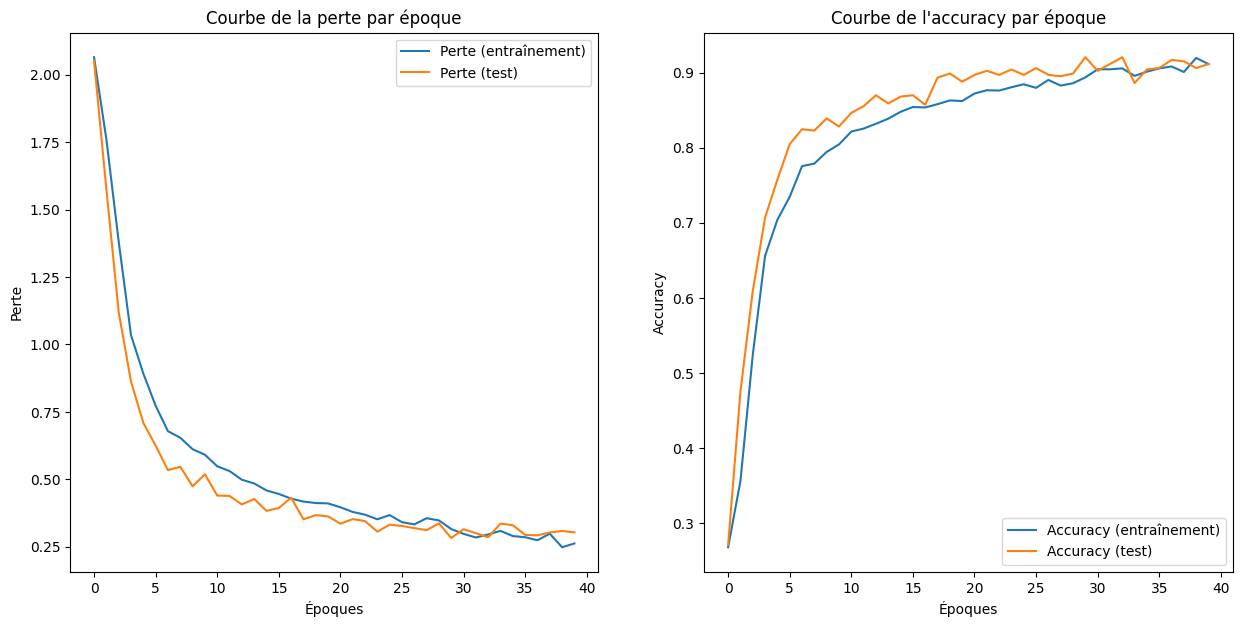

In [11]:
plt.figure(figsize=(15,7))

plt.subplot(121)
# Affichage de la perte par époque
plt.plot(history.history['loss'], label='Perte (entraînement)')
plt.plot(history.history['val_loss'], label='Perte (test)')
plt.title('Courbe de la perte par époque')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(122)
# Affichage de l'accuracy par époque
plt.plot(history.history['accuracy'], label='Accuracy (entraînement)')
plt.plot(history.history['val_accuracy'], label='Accuracy (test)')
plt.title('Courbe de l\'accuracy par époque')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [97]:
# Sauvegarde du modèle entraîné
fitted_model.save(f"{results_dir}/final_cnn.keras")

# 6. Evaluation

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(fitted_model,test_ds):
    # Prédiction
    y_true,y_pred = get_predictions_and_labels(fitted_model,test_ds)
    y_true_names = encoder.inverse_transform(y_true)
    y_pred_names = encoder.inverse_transform(y_pred)
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_true_names, y_pred_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies classes")
    plt.title("Matrice de confusion")
    plt.show()
    # Rapport de classification
    class_report = classification_report(y_true_names, y_pred_names)
    print("Rapport de classification :\n", class_report)
    return y_true_names,y_pred_names

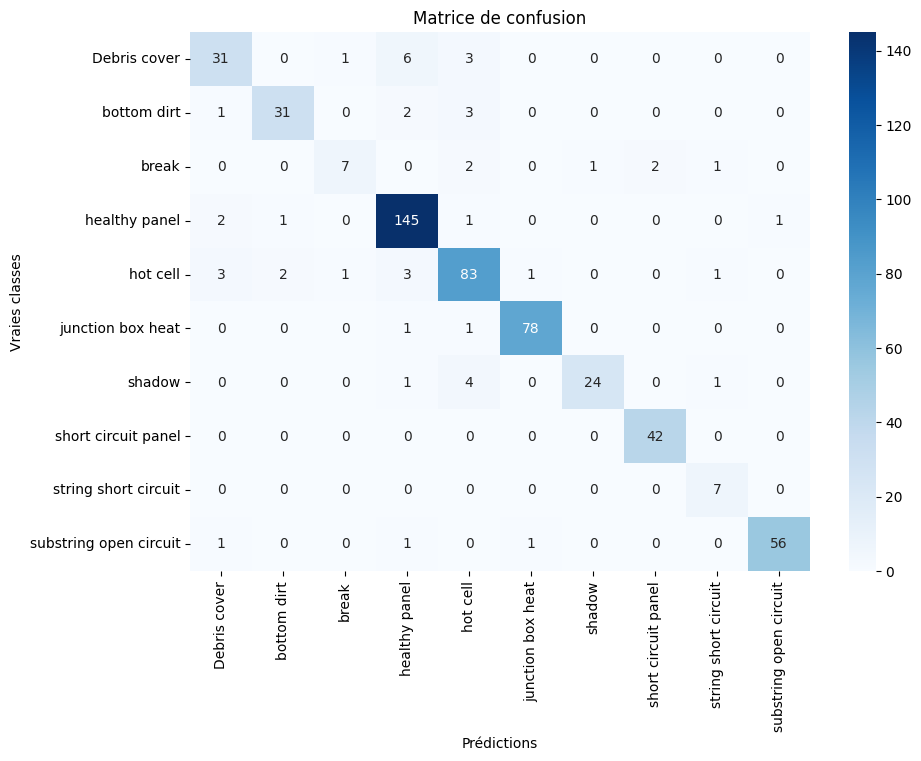

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.82      0.76      0.78        41
           bottom dirt       0.91      0.84      0.87        37
                 break       0.78      0.54      0.64        13
         healthy panel       0.91      0.97      0.94       150
              hot cell       0.86      0.88      0.87        94
     junction box heat       0.97      0.97      0.97        80
                shadow       0.96      0.80      0.87        30
   short circuit panel       0.95      1.00      0.98        42
  string short circuit       0.70      1.00      0.82         7
substring open circuit       0.98      0.95      0.97        59

              accuracy                           0.91       553
             macro avg       0.88      0.87      0.87       553
          weighted avg       0.91      0.91      0.91       553



In [13]:
y_true_names,y_pred_names = evaluate_model(fitted_model,test_ds)

On a une bonne généralisation. Avec le découpage proposé par les constructeurs du dataset (90% / 10%), on est à : **91% d'accuracy et 87% de f1-score**. Pour rappel dans leur article de recherche, le meilleur score atteint avec des modèles de Deep Learning pour les images 110x60 était de 92% d'accuracy et 91% de f1-score.

In [14]:
# Affichage des classes les + confondues
import itertools
conf_matrix_norm = confusion_matrix(y_true_names, y_pred_names,normalize='true')
classes_confondues=[]
for (reel,predit) in itertools.product(range(conf_matrix_norm.shape[0]), range(conf_matrix_norm.shape[1])):
    if (reel != predit and conf_matrix_norm[reel,predit]> 0.1):
        classes_confondues.append((encoder.classes_[reel],encoder.classes_[predit],conf_matrix_norm[reel,predit]*100))
print ("Classes confondues :")
print (*[f"Réel : {paire[0]} - Prédit : {paire[1]} ({paire[2]:.2f} %)" for paire in classes_confondues],sep = '\n')

Classes confondues :
Réel : Debris cover - Prédit : healthy panel (14.63 %)
Réel : break - Prédit : hot cell (15.38 %)
Réel : break - Prédit : short circuit panel (15.38 %)
Réel : shadow - Prédit : hot cell (13.33 %)


Comme pour les modèles classiques de machine learning, les classes moins représentées Break et String short circuit ont des résultats moins bons. En revanche, on note une amélioration assez nette concernant la classe Debris cover qui représente des défauts de petite taille. 

# 7. Avec les images du format original

### Chargement du dataframe

In [15]:
X_train_ori,X_test_ori,y_train_ori,y_test_ori = load_df_from_dataset(csv_pvf10,format="Ori",originalTrainTest="True")

print ("Nb d'images ensemble d'entraînement :",X_train_ori.shape[0])
print ("Nb d'images ensemble de test :",X_test_ori.shape[0])
print ("-"*20)
print ("Répartition des classes, ensemble d'entraînement :")
print(y_train_ori.value_counts(normalize=True))
print ("-"*20)
print ("Répartition des classes, ensemble de test :")
print(y_test_ori.value_counts(normalize=True))

Nb d'images ensemble d'entraînement : 5019
Nb d'images ensemble de test : 553
--------------------
Répartition des classes, ensemble d'entraînement :
Classe
healthy panel             0.271967
hot cell                  0.169356
junction box heat         0.143455
substring open circuit    0.106595
short circuit panel       0.076709
Debris cover              0.073521
bottom dirt               0.067743
shadow                    0.054393
break                     0.023511
string short circuit      0.012752
Name: proportion, dtype: float64
--------------------
Répartition des classes, ensemble de test :
Classe
healthy panel             0.271248
hot cell                  0.169982
junction box heat         0.144665
substring open circuit    0.106691
short circuit panel       0.075949
Debris cover              0.074141
bottom dirt               0.066908
shadow                    0.054250
break                     0.023508
string short circuit      0.012658
Name: proportion, dtype: float64


### Preprocessing

On choisit de redimensionner les images du format original en 112x112

In [16]:
# Features : récupération des chemins d'images
X_train_ori_path = X_train_ori['Chemin'].values
X_test_ori_path = X_test_ori['Chemin'].values

# Targets : Encodage des classes en entier
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_ori_enc = encoder.fit_transform(y_train_ori)
y_test_ori_enc = encoder.transform(y_test_ori)

# Fonction de preprocessing
from PIL import Image
def pil_loader(path):
    # Lire l'image avec PIL
    image = Image.open(path.numpy().decode("utf-8")).convert("L")  # "L" = niveaux de gris
    image = image.resize((112, 112))  # Redimensionnement
    image = np.array(image, dtype=np.float32)
    image = np.expand_dims(image, axis=-1)  # Ajoute un canal pour correspondre à (H, W, 1)
    return image

def preprocess_path_ori(path, label):
    image = tf.py_function(func=pil_loader, inp=[path], Tout=tf.float32) # On encapsule la fonction Python pil_loader
    image.set_shape([112, 112, 1])  # Définir la forme du tenseur attendue pour TensorFlow
    return image, label

# Création des datasets tensorflow
train_ori_ds = tf.data.Dataset.from_tensor_slices((X_train_ori_path, y_train_ori_enc))
test_ori_ds = tf.data.Dataset.from_tensor_slices((X_test_ori_path, y_test_ori_enc))

# Preprocessing
train_ori_ds = train_ori_ds.map(preprocess_path_ori, num_parallel_calls=tf.data.AUTOTUNE)
test_ori_ds = test_ori_ds.map(preprocess_path_ori, num_parallel_calls=tf.data.AUTOTUNE)

# Optimisation de la pipeline
BATCH_SIZE = 32
# Faire un shuffle sur train, car pas de train_test_split effectué ici => les classes ne sont pas encore mélangées
train_ori_ds = train_ori_ds.shuffle(len(X_train_ori_path)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ori_ds = test_ori_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Nombre de batch dans train_ds:", train_ori_ds.cardinality().numpy())
print("Nombre de batch dans test_ds:", test_ori_ds.cardinality().numpy())

Nombre de batch dans train_ds: 157
Nombre de batch dans test_ds: 18


### Construction du modèle

On se base sur la même architecture que celle choisie pour le format 110x60.

Pour les augmentations de données, on applique en plus une rotation.

In [17]:
from tensorflow.keras.layers import RandomRotation

# Construction du modèle
def build_model_ori():
    # Entrée
    inputs = Input(shape=(112,112,1))

    # Augmentation
    x = RandomRotation(0.1)(inputs)
    x = RandomFlip("horizontal_and_vertical")(x)
    x = RandomBrightness(factor=0.1)(x)
    x = RandomContrast(factor=0.1)(x)
    x = GaussianNoise(0.03)(x)

    # Normalisation
    x = Rescaling(scale=1./255.)(inputs)
    
    # Couches de convolution
    for num_block in range(4):
        x = Conv2D(filters=16 * (2**num_block), kernel_size=(3,3), padding="same", activation ="relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)

    # Passage 1-D pour la classification
    x = Flatten()(x)

    # Couche de classification
    x = Dense(units = 64, activation='relu')(x)

    # Sortie
    outputs = Dense(units = 10, activation = 'softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return(model)

### Entraînement

On utilise les mêmes paramètres d'entraînement que pour le format 110x60

In [18]:
# Fonction d'entraînement du modèle avec paramètres choisis
def train_model_ori(train_ds,nb_epoques,tx_appr) : 
    
    # Construire le modèle pour le format original
    model = build_model_ori()

    # Le compiler avec optimiseur Adam et fonction de perte adaptée aux problèmes multi-classes
    model.compile(loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(tx_appr),
        metrics=["accuracy"])

    # L'entraîner
    history = model.fit(train_ds, epochs=nb_epoques)

    # Afficher le compte-rendu des résultats
    return model,history

In [21]:
# On entraîne le modèle sur l'ensemble train du format original
fitted_model_ori,history = train_model_ori(train_ori_ds,40,0.001)

Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.2917 - loss: 1.9985
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.5056 - loss: 1.4316
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.6578 - loss: 1.0443
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.7585 - loss: 0.7400
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.7790 - loss: 0.6753
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.8121 - loss: 0.5843
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8222 - loss: 0.5240
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8476 - loss: 0.4510
Epoch 9/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.8497 - loss: 0.4335
Epoch 10/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.8544 - loss: 0.4128
Epoch 11/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8781 - loss: 0.3542
Epoch 12/40
157/157 ━━━━━━━━━━

### Evaluation

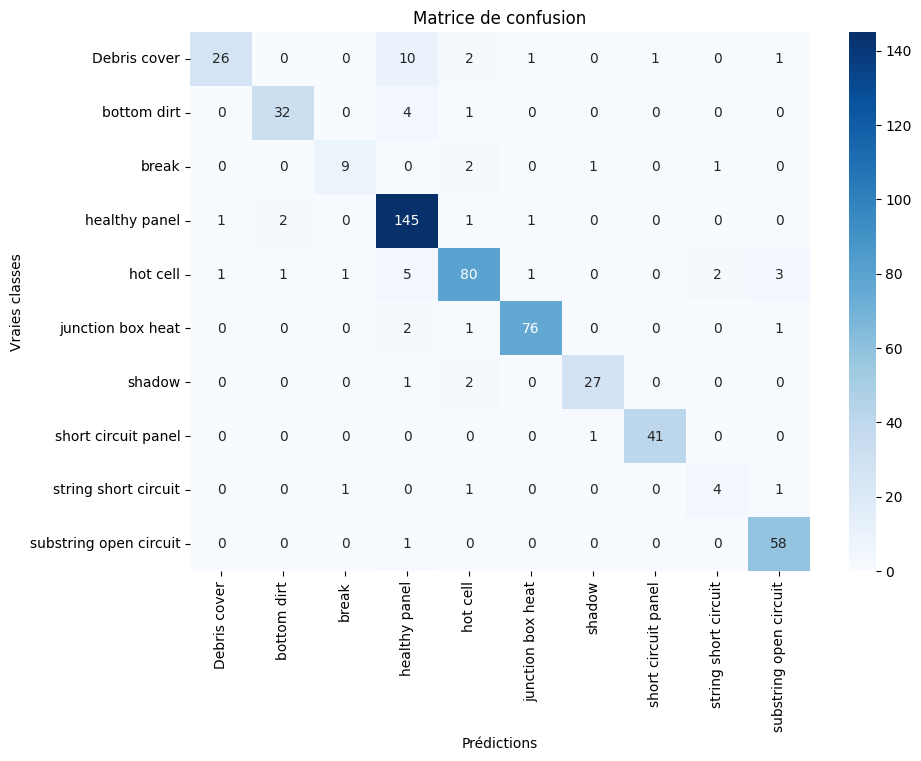

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.93      0.63      0.75        41
           bottom dirt       0.91      0.86      0.89        37
                 break       0.82      0.69      0.75        13
         healthy panel       0.86      0.97      0.91       150
              hot cell       0.89      0.85      0.87        94
     junction box heat       0.96      0.95      0.96        80
                shadow       0.93      0.90      0.92        30
   short circuit panel       0.98      0.98      0.98        42
  string short circuit       0.57      0.57      0.57         7
substring open circuit       0.91      0.98      0.94        59

              accuracy                           0.90       553
             macro avg       0.88      0.84      0.85       553
          weighted avg       0.90      0.90      0.90       553



In [22]:
y_true_ori_names,y_pred_ori_names = evaluate_model(fitted_model_ori,test_ori_ds)

Avec les image dans le format original, on est à : **90% d'accuracy et 85% de f1-score**, soit très proche du format 110x60 ! Pour rappel dans leur article de recherche, le meilleur score atteint avec des modèles de Deep Learning pour les images au format original était de 91% d'accuracy et 87% de f1-score.

# 8. Interprétabilité

On récupère les images de test après preprocessing (redimensionnées en 110x60 et converties en niveaux de gris)

Nous allons étudier l'interprétabilité de ces images par notre réseau de neurones.

In [ ]:
# Récupérer une image de chaque classe d'un dataset
def get_one_image_per_class(dataset, num_classes=10):
    # Stockage des images dans un dictionnaire
    images_per_class = {} 
    # Pour chaque batch
    for batch_images, batch_labels in dataset:
        # Pour chaque image / label
        for img, label in zip(batch_images, batch_labels):
            # Convertir les images en array d'entiers
            img = img.numpy().astype(np.uint8)
            # Convertir les labels en nom de classe
            label = encoder.classes_[label.numpy()]
            # Si la classe n'a pas encore été ajoutée
            if label not in images_per_class:
                # On l'ajoute avec l'image associée
                images_per_class[label] = img
                # On s'arrête quand on atteint le nb de classes demandé
                if len(images_per_class) == num_classes:
                    return images_per_class

# On récupère ue image de chaque classe dans l'ensemble test 110x60
# C'est un dictionnaire dont la clé est le nom de la classe
my_images = get_one_image_per_class(test_ds)              

In [39]:
# Chargement du modèle entraîné sur les images 110x60
from tensorflow.keras.models import load_model
model_loaded = load_model(f"{results_dir}/final_cnn.keras")

### Interprétabilité GRAD-CAM

On va analyser nos 4 couches de convolution afin d'identifier les zones de l'image utilisées pour la classe prédite.

In [40]:
# Fonction GRAD_CAM pour la classe prédite d'une image par rapport à une couche de convolution d'un modèle
# En entrée : une image, un modèle entraîné, et le nom d'une couche de convolution.
# En sortie : une image superposée avec la carte de chaleur générée par Grad-CAM
def grad_cam(image, model, layer_name):
    # Récupérer la couche convolutive
    layer = model.get_layer(layer_name)
    
    # Créer un modèle qui génère les sorties de la couche convolutive et les prédictions
    grad_model = Model(inputs=model.input, outputs=[layer.output, model.output])

    # Ajout d'une dimension de batch
    image = tf.expand_dims(image, axis=0)

    # Calcul des gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image,training=False)
        predicted_class = tf.argmax(predictions[0])  # Classe prédite
        loss = predictions[:, predicted_class]  # Perte pour la classe prédite

    # Gradients des scores par rapport aux sorties de la couche convolutive
    grads = tape.gradient(loss, conv_outputs)

    # Moyenne pondérée des gradients pour chaque canal
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Pondération des activations par les gradients calculés
    conv_outputs = conv_outputs[0]  # Supprimer la dimension batch
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalisation de la carte de chaleur
    heatmap = tf.maximum(heatmap, 0)  # Se concentrer uniquement sur les valeurs positives
    heatmap /= tf.math.reduce_max(heatmap)  # Normaliser entre 0 et 1
    heatmap = heatmap.numpy()  # Convertir en tableau numpy pour la visualisation

   # Redimensionner la carte de chaleur pour correspondre à la taille de l'image d'origine
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (image.shape[1], image.shape[2])).numpy()
    heatmap_resized = np.squeeze(heatmap_resized, axis=-1) # supprimer la dimension de taille 1 à la fin du tableau heatmap_resized

    # Colorier la carte de chaleur avec une palette (par exemple, "jet")
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3] # Récupérer les canaux R, G, B 

    superimposed_image = heatmap_colored * 0.7 + image[0].numpy() / 255.0

    return np.clip(superimposed_image, 0, 1), predicted_class

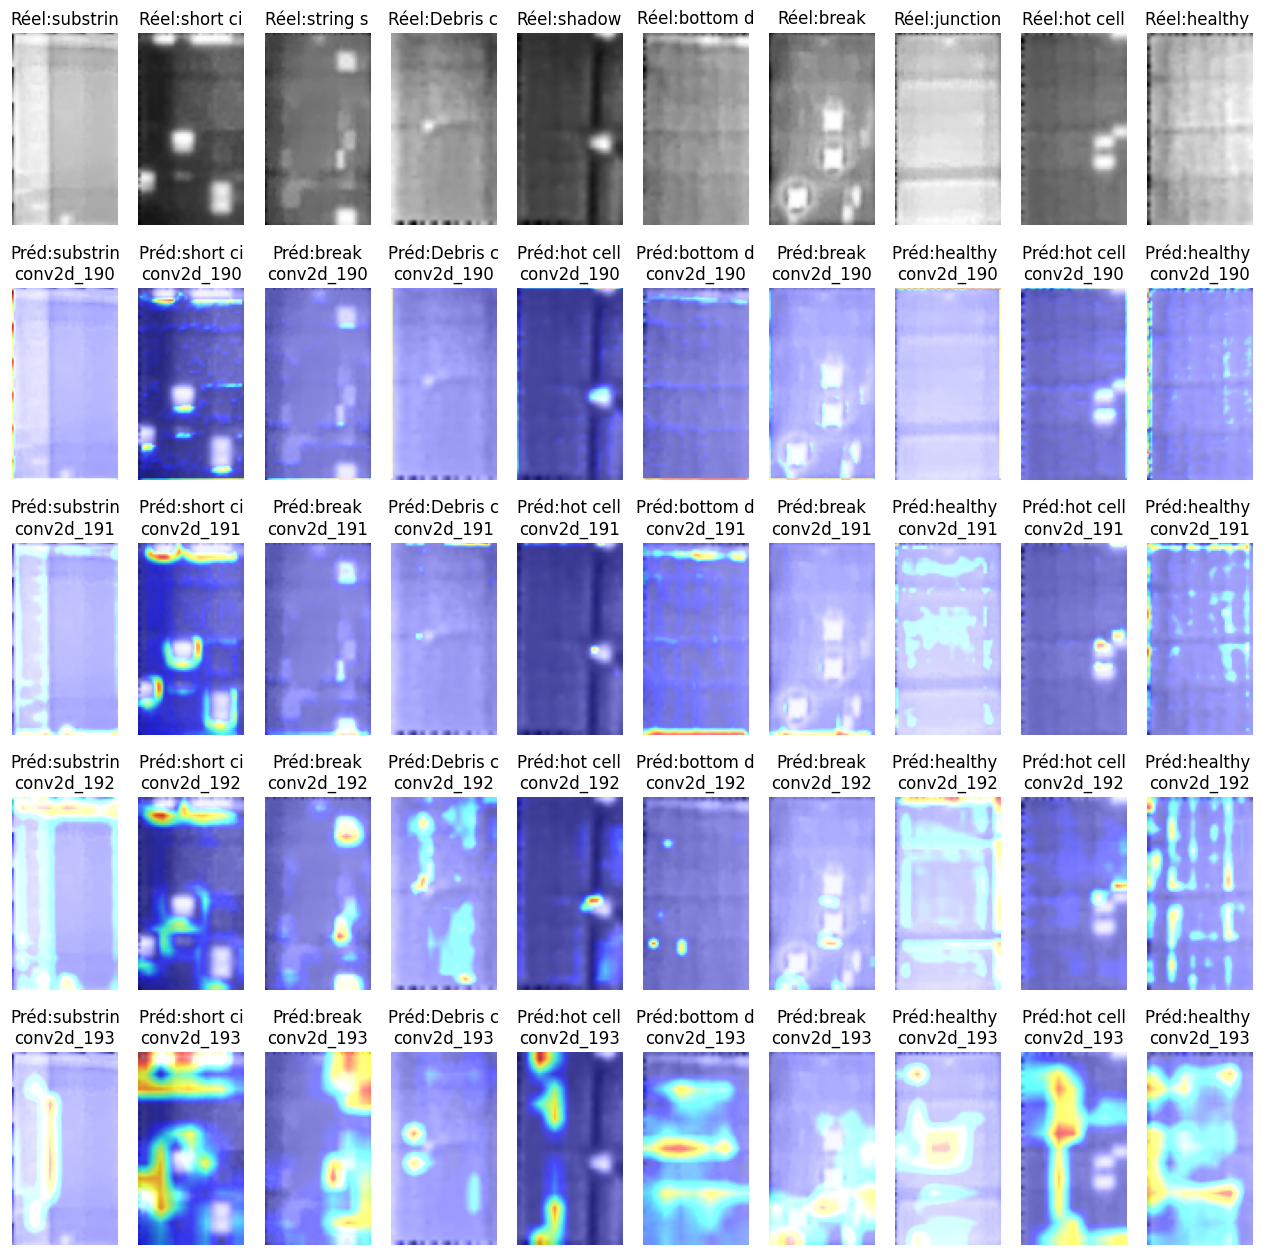

In [ ]:
# Fonction d'affichage GRAD-CAM pour toutes les couches de convolution du modèle
# En entrée : des images et un modèle entraîné
def show_grad_cam_cnn(images, model):
    number_of_images = len (images)
    conv_layers = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

    plt.figure(figsize=(16,16))

    # Affichage des images en entrée du modèle
    for i,(classe,image) in enumerate(images.items()):

        plt.subplot(1+len(conv_layers), number_of_images, i+1)
        plt.imshow(image,cmap='gray')
        plt.title(f"Réel:{classe[:8]}")
        plt.axis("off")

    # Affichage des images avec Grad-CAM pour chaque couche de convolution
    for j, layer in enumerate(conv_layers):

        for i,(classe,image) in enumerate(images.items()):

            subplot_index = i + 1 + (j+1) * number_of_images
            plt.subplot(1+len(conv_layers), number_of_images, subplot_index)

            # Obtenir l'image avec la carte de chaleur superposée
            grad_cam_image, predicted_class = grad_cam(image, model, layer)
            
            # Afficher l'image avec Grad-CAM
            plt.title(f"Préd:{encoder.classes_[predicted_class][:8]}\n{layer}")
            plt.imshow(grad_cam_image)
            plt.axis("off")

    plt.show()

show_grad_cam_cnn(my_images, model_loaded)

Vérifions les zones utilisées par notre modèle pour chacune des images : 
- substring open circuit : la bande verticale en défaut a bien été identifiée
- short circuit panel : les grosses variations de température sur les différentes cellules ont été identifiées dès les premières couches de convolution
- string short circuit (prédit break à tort) : les cellules en défaut ont bien été identifiées, mais notre modèle les a classées Break. Il n'a pas perçu l'alignement susceptible de faire passer le défaut en string short circuit
- debris cover : le modèle a réussi à détecter le petit défaut engendré par le débris dès les premières couches de convolution
- shadow (prédit hot cell à tort) : notre modèle s'est focalisé sur une zone intense de l'image et a considéré que le défaut était localisé sur cette cellule.
- bottom dirt : on voit sur les premières couches de convolution que le modèle a analysé les bords supérieurs et inférieurs de l'image
- break : les zones défaillantes ont bien été identifiées
- junction box (prédit healthy à tort): la variation de température engendrée par la junction box est trop faible et n'a pas été prise en compte par le modèle
- hot cell : les cellules en défaut ont été identifiées dans les premières couches de convolution
- healthy panel : le panneau semble avoir été analysé dans son ensemble à travers les différentes couches de convolution.

**Les zones de l'image activées par notre modèle sont assez cohérentes avec les classes prédites.**

### Interprétabilité SHAP

Nous allons nous concentrer sur les 3 images ci-dessus mal prédites par le modèle et analyser avec SHAP les causes de cette classification

In [74]:
# Récupération des images en erreur
error_keys = ['string short circuit', 'shadow','junction box heat']
error_images = np.stack([my_images[k] for k in error_keys]) # Transformation liste en array => (3,110,60,1)

# On affiche les probabilités prédites pour ces images
error_preds = model_loaded.predict(error_images)
display(pd.DataFrame(np.round(error_preds*100,2),index=error_keys,columns=encoder.classes_))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


,Debris cover,bottom dirt,break,healthy panel,hot cell,junction box heat,shadow,short circuit panel,string short circuit,substring open circuit
string short circuit,0.64,0.00,95.849998,0.000000,0.050000,0.0,0.02,0.01,3.42,0.00
shadow,0.00,0.06,0.000000,0.000000,92.199997,0.0,7.71,0.00,0.03,0.00
junction box heat,4.23,0.01,0.040000,90.269997,0.790000,2.1,2.41,0.00,0.00,0.13


PartitionExplainer explainer: 4it [01:11, 23.70s/it]                       


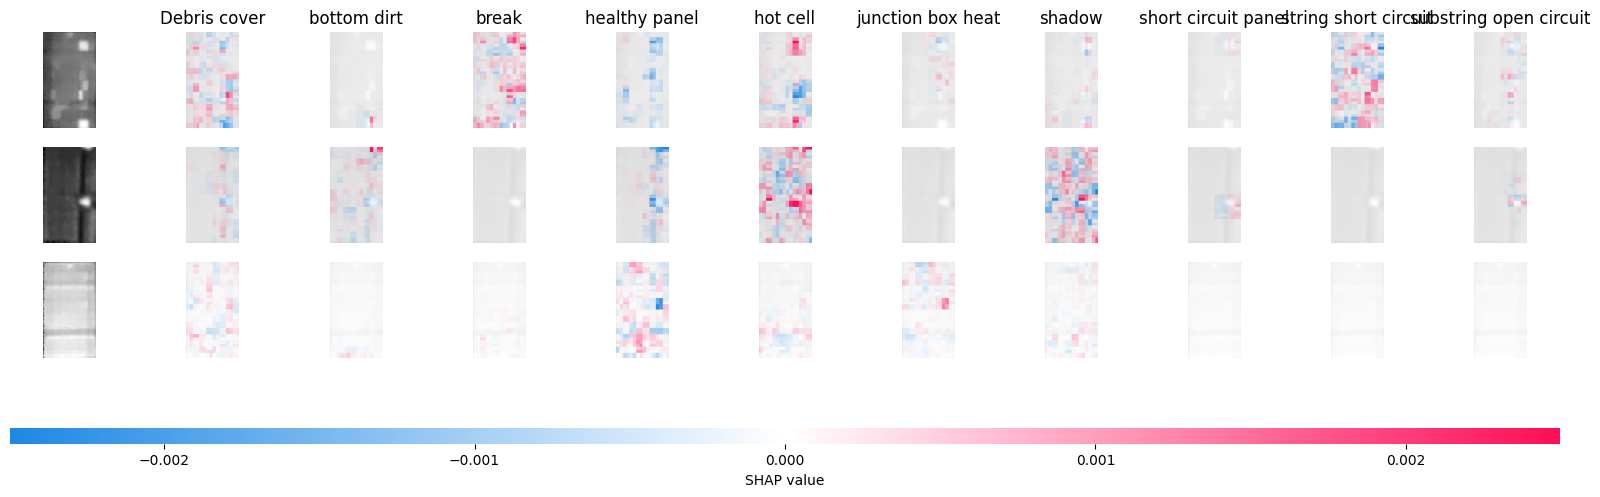

In [79]:
# Initialiser le masker SHAP
import shap

# Initialiser le masker SHAP
masker = shap.maskers.Image("inpaint_telea", (110,60,1))

# Créer l'explainer SHAP
explainer = shap.Explainer(model_loaded, masker, output_names=encoder.classes_)

# Calculer les valeurs SHAP pour les images qu'on veut expliquer
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
shap_values = explainer(error_images, max_evals=5000)

# Afficher les images SHAP
shap.image_plot(shap_values)

On note sur ces 3 images les "hésitations" du modèle :
- string short circuit : les cellules en défaut contribuent positivement à la classe String short circuit, mais également à la classe Break. Le fait qu'il y ait des variations d'intensité dans d'autres zones de l'image (pas seulement sur une ligne) fait pencher la balance vers la classe break.
- shadow : la zone intense localisée à droite de l'image contribue fortement à la classe hot cell, bien plus que shadow. On remarque qu'une autre zone brillante en haut à droite y contribue aussi.
- junction box heat : le défaut localisé en haut au milieu du panneau n'entraîne pas de perturbation locale suffisamment importante pour être considéré par le modèle.

Notre modèle peut parfois se tromper, lorsque le défaut concerné entraîne des variations trop faibles par rapport au bruit ambiant (junction box heat, debris cover...), ou lorsqu'il se focalise sur une zone en particulier alors que le défaut est plus général (shadow...). A noter que parmi ces cas d'erreur, les défauts en question ne sont pas non plus toujours faciles à distinguer pour un observateur humain.

# 9. Généralisation hors dataset

In [ ]:
# Chargement du modèle entraîné sur les images 110x60
from tensorflow.keras.models import load_model
model_loaded = load_model(f"{results_dir}/final_cnn.keras")
model_loaded.summary()

Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 110, 60, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_24 (RandomFlip)     │ (None, 110, 60, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_25            │ (None, 110, 60, 1)     │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_21              │ (None, 110, 60, 1)     │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_24               │ (None, 110, 60, 1)     │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_50 (Rescaling)        │ (None, 110, 60, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_190 (Conv2D)             │ (None, 110, 60, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_182               │ (None, 55, 30, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_204 (Dropout)           │ (None, 55, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_191 (Conv2D)             │ (None, 55, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_183               │ (None, 27, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_205 (Dropout)           │ (None, 27, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_192 (Conv2D)             │ (None, 27, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_184               │ (None, 13, 7, 64)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 13, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_193 (Conv2D)             │ (None, 13, 7, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_185               │ (None, 6, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 6, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 735,968 (2.81 MB)

 Trainable params: 245,322 (958.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 490,646 (1.87 MB)

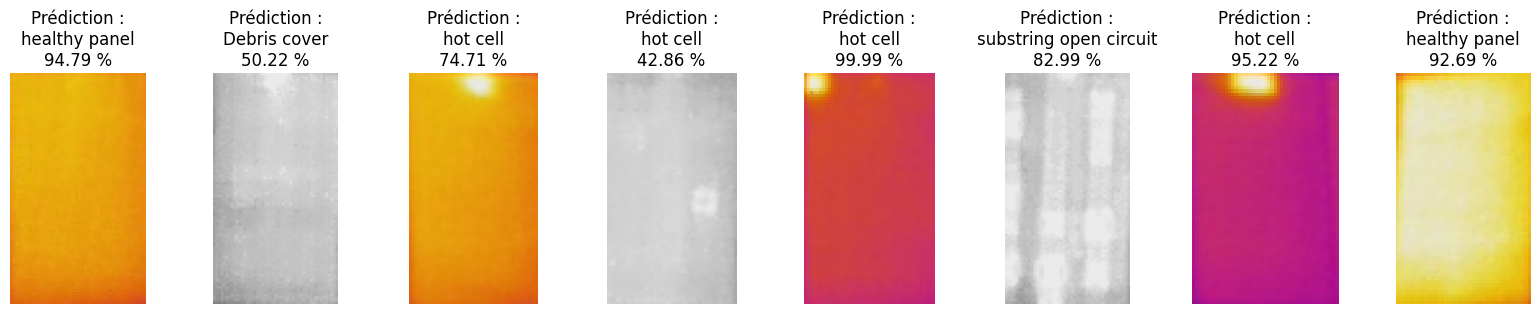

In [170]:
import matplotlib.image as mpimg

# Quelques images de test hors dataset pour la prédiction
plt.figure(figsize=(20, 3))

for i,unit_test_path in enumerate(["UT_images_ext/UT_healthy.png",
                                   "UT_images_ext/UT_junction_box.png",
                                   "UT_images_ext/UT_junction_box_2.png",
                                   "UT_images_ext/UT_one_cell.png",
                                   "UT_images_ext/UT_one_cell_2.png",
                                   "UT_images_ext/UT_multi_cell.png",
                                   "UT_images_ext/UT_multi_cell_2.png",
                                   "UT_images_ext/UT_module.png"]):
    # Faire passer l'image dans le preprocessing
    img,_ = preprocess_path(unit_test_path,"")
    # Ajouter une dimension (=> conforme à l'entrée du modèle en batches)
    img = np.expand_dims(img, axis = 0)
    # Prédire les résultats pour l'image
    preds = model_loaded.predict(img,verbose=0)
    class_pred = encoder.classes_[np.argmax(preds,axis=1)[0]]
    proba_class_pred = np.max(preds,axis=1)[0] * 100
    # Afficher l'image et sa classe prédite
    plt.subplot(1, 8, i+1)
    img = mpimg.imread(unit_test_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prédiction :\n{class_pred}\n{proba_class_pred:.2f} %")

plt.show()

Même si ce sont des images extérieures au dataset original, les prédictions semblent correctes dans l'ensemble. Il n'y a pas d'erreur "flagrante".